# HYSPLIT + AirNow ConvLSTM Experiment

## Configuration Setup

In [1]:
import os
# define bounding box
lat_bottom, lat_top = 33.9, 34.2
lon_bottom, lon_top = -118.4, -118.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-13-00"

# Define paths
base_dir = "/mnt/d/school/wildfire/hysplit/organized/hysplit/HYSPLIT"
working_dir = os.path.join(base_dir, "working")
exec_dir = os.path.join(base_dir, "exec")
bdy_files_dir = os.path.join(base_dir, "bdyfiles")
graphics_dir = os.path.join(base_dir, "graphics")
output_dir = "/mnt/d/school/wildfire/hysplit/organized/data/conc_output"
convlstm_output_dir = "convlstm_data"   # Directory for processed data

# Meteorological data file
met_file = "gdas1.jan25.w2" 

## HYSPLIT Data Processing

In [2]:
# Import required libraries
import os
import subprocess
import shutil
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pickle

# Import our custom modules
from libs.hysplitdata_module import HYSPLITData
from libs.airnowdata_module import AirNowData

In [3]:
# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

# Create convlstm_output directory if it doesn't exist
if not os.path.exists(convlstm_output_dir):
    os.makedirs(convlstm_output_dir)
    print(f"Created ConvLSTM output directory: {convlstm_output_dir}")

In [4]:
# Initialize HYSPLIT data processor
HD = HYSPLITData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    base_dir=base_dir,
    working_dir=working_dir,
    exec_dir=exec_dir,
    bdy_files_dir=bdy_files_dir,
    output_dir=output_dir,
    met_file=met_file,
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)

Running HYSPLIT simulation...
Created CONTROL file for date: 25-01-10 00:00
 HYSPLIT - Initialization 
 HYSPLIT version: hysplit.v5.3.4
 Last Changed Date: 2025-01-27
 Calculation Started ... please be patient
 Percent complete:   1.4
 Percent complete:   2.8
 Percent complete:   4.2
 Percent complete:   5.6
 Percent complete:   6.9
 Percent complete:   8.3
 Percent complete:   9.7
 Percent complete:  11.1
 Percent complete:  12.5
 Percent complete:  13.9
 Percent complete:  15.3
 Percent complete:  16.7
 Percent complete:  18.1
 Percent complete:  19.4
 Percent complete:  20.8
 Percent complete:  22.2
 Percent complete:  23.6
 Percent complete:  25.0
 Percent complete:  26.4
 Percent complete:  27.8
 Percent complete:  29.2
 Percent complete:  30.6
 Percent complete:  31.9
 Percent complete:  33.3
 Percent complete:  34.7
 Percent complete:  36.1
 Percent complete:  37.5
 Percent complete:  38.9
 Percent complete:  40.3
 Percent complete:  41.7
 Percent complete:  43.1
 Percent comple

In [5]:
X_hysplit = HD.data
print(X_hysplit.shape)

(1823, 5, 200, 200, 1)


Displaying HYSPLIT frames for example 1252.


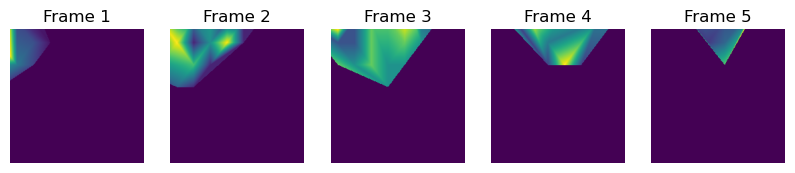

In [6]:
# Visualize HYSPLIT data frames
import matplotlib.pyplot as plt
import numpy as np

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
np.random.seed(150)
rand_sample = np.random.choice(range(len(X_hysplit)))
for idx, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_hysplit[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying HYSPLIT frames for example {rand_sample}.")
plt.show()

## AirNow preprocessing

In [7]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get API key from environment
airnow_api_key = os.environ.get('AIRNOW_API_KEY')
# Initialize AirNow data processor
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=airnow_api_key,  # API key from environment variable
    save_dir='data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim,
    idw_power=2,
    elevation_path="libs/inputs/elevation.npy",
    mask_path="libs/inputs/mask.npy",
)

'data/airnow.json' already exists; skipping request...


In [8]:
X_airnow = AD.data
Y = AD.target_stations
print(X_airnow.shape)
print(Y.shape)

(69, 5, 200, 200, 1)
(69, 3)


# Test IDW implentation

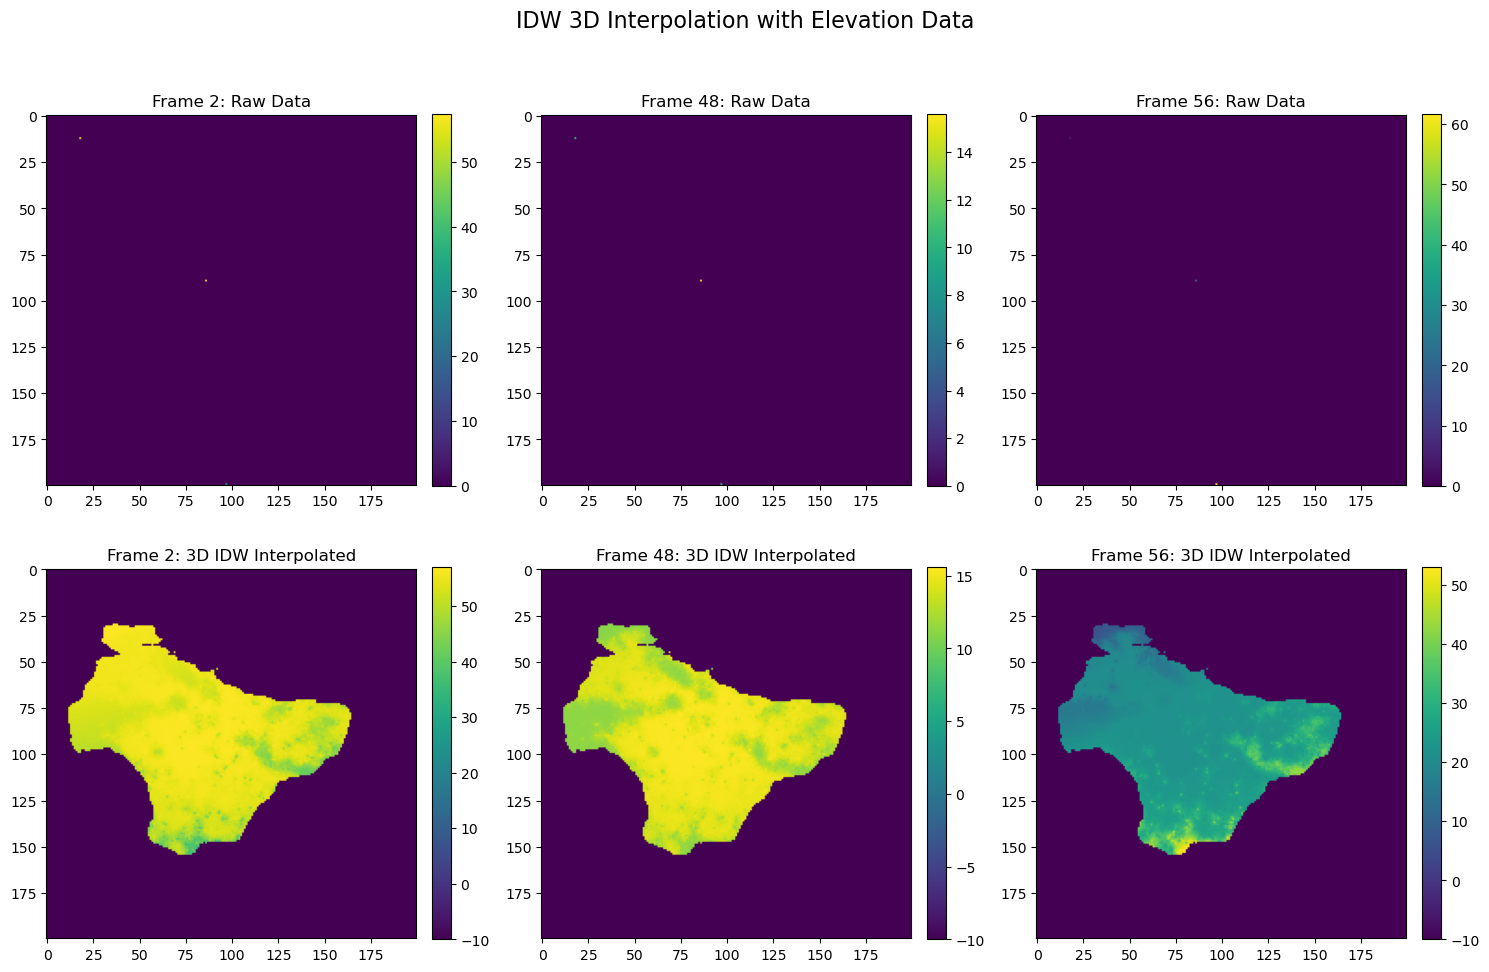

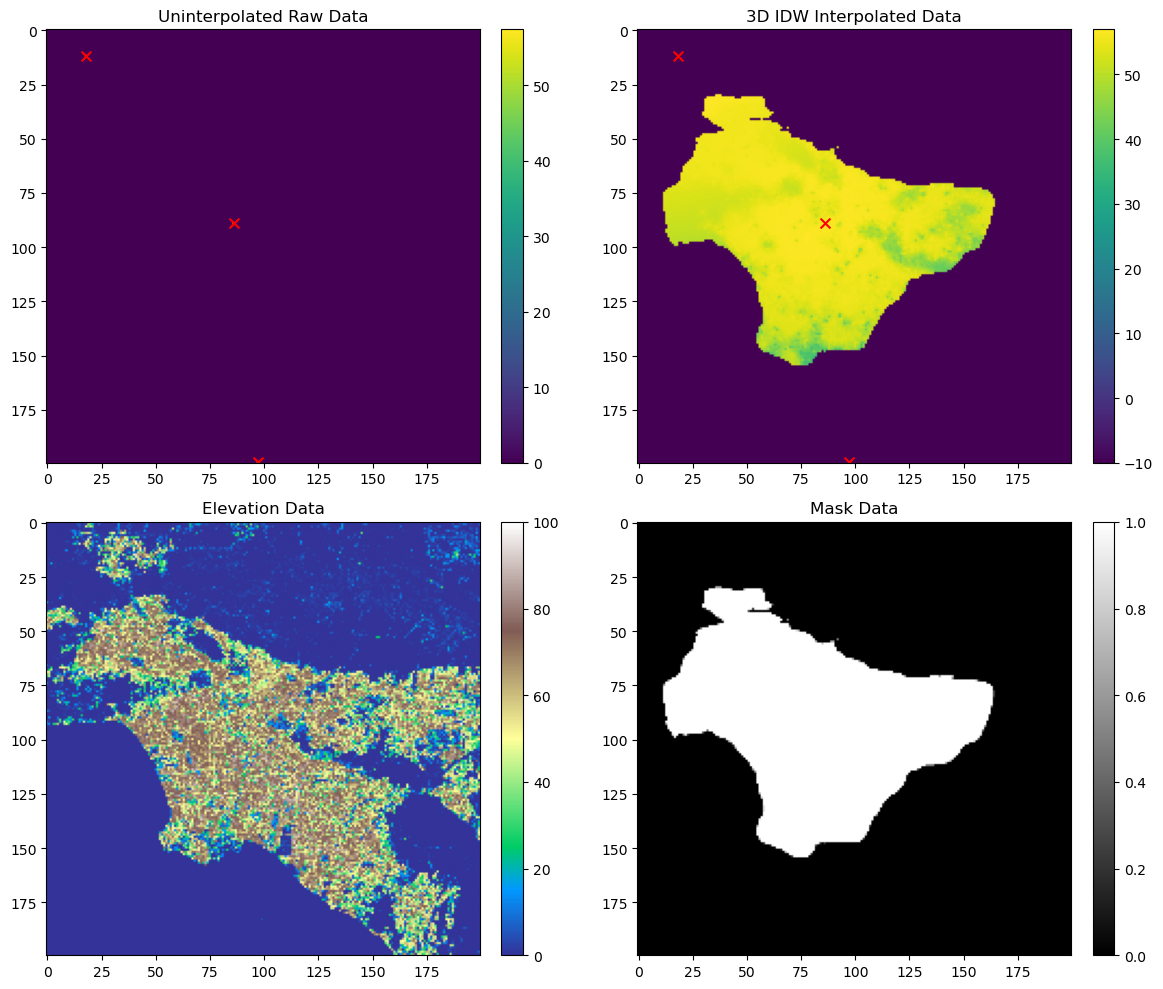

Total frames: 73
Number of sensor locations: 3
Sensor locations: ['North Holywood', 'Los Angeles - N. Main Street', 'Compton']
Grid dimensions: 200x200
IDW power parameter: 2


In [9]:
import matplotlib.pyplot as plt

# Create a figure to display some raw and interpolated frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle('IDW 3D Interpolation with Elevation Data', fontsize=16)

# Select 3 random frame indices to display
import random
num_frames = len(AD.ground_site_grids)
display_indices = random.sample(range(num_frames), min(3, num_frames))

for i, idx in enumerate(display_indices):
    # Display original uninterpolated grid
    im1 = axes[0, i].imshow(AD.ground_site_grids[idx], cmap='viridis')
    axes[0, i].set_title(f'Frame {idx}: Raw Data')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Display interpolated grid (extracting from the processed dataset)
    # Find which sample and time step this frame corresponds to
    sample_idx = max(0, idx - AD.frames_per_sample + 1)
    time_idx = idx - sample_idx if idx - sample_idx < AD.frames_per_sample else 0
    
    if sample_idx < AD.data.shape[0] and time_idx < AD.data.shape[1]:
        im2 = axes[1, i].imshow(np.squeeze(AD.data[sample_idx, time_idx]), cmap='viridis')
        axes[1, i].set_title(f'Frame {idx}: 3D IDW Interpolated')
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Display a single frame in more detail
if num_frames > 0:
    detail_idx = display_indices[0]
    
    plt.figure(figsize=(12, 10))
    
    # Plot the original uninterpolated grid
    plt.subplot(2, 2, 1)
    plt.imshow(AD.ground_site_grids[detail_idx], cmap='viridis')
    plt.title('Uninterpolated Raw Data')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    # Find and mark sensor locations
    sensor_locs = np.array(list(AD.air_sens_loc.values()))
    if len(sensor_locs) > 0:
        plt.scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='red', s=50, marker='x')
    
    # Plot the interpolated grid
    sample_idx = max(0, detail_idx - AD.frames_per_sample + 1)
    time_idx = detail_idx - sample_idx if detail_idx - sample_idx < AD.frames_per_sample else 0
    
    if sample_idx < AD.data.shape[0] and time_idx < AD.data.shape[1]:
        plt.subplot(2, 2, 2)
        plt.imshow(np.squeeze(AD.data[sample_idx, time_idx]), cmap='viridis')
        plt.title('3D IDW Interpolated Data')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        # Mark sensor locations on the interpolated grid
        if len(sensor_locs) > 0:
            plt.scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='red', s=50, marker='x')
    
    # Plot the elevation data
    plt.subplot(2, 2, 3)
    plt.imshow(AD.elevation, cmap='terrain')
    plt.title('Elevation Data')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    # Plot the mask
    plt.subplot(2, 2, 4)
    plt.imshow(AD.mask, cmap='gray')
    plt.title('Mask Data')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Print information about the interpolation
    print(f"Total frames: {num_frames}")
    print(f"Number of sensor locations: {len(AD.air_sens_loc)}")
    print(f"Sensor locations: {list(AD.air_sens_loc.keys())}")
    print(f"Grid dimensions: {AD.dim}x{AD.dim}")
    print(f"IDW power parameter: {AD.idw_power}")

## Joint preprocessing
- Split into train/test sets
- Scale train/test sets independently
- Combine X datasets into 1 with 2 channels

In [10]:
# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [11]:
import numpy as np

# split data
X_hysplit_train, X_hysplit_test = train_test_split(X_hysplit, train_size=0.75)
X_airnow_train, X_airnow_test = train_test_split(X_airnow, train_size=0.75)
y_train, y_test = train_test_split(Y, train_size=0.75)

# scale training data, then test data based on training data's stats
# First, align your datasets
min_samples = min(X_hysplit.shape[0], X_airnow.shape[0])
X_hysplit = X_hysplit[:min_samples]
X_airnow = X_airnow[:min_samples]
Y = Y[:min_samples]

split_idx = int(min_samples * 0.75)

# Split all datasets using the same index
X_hysplit_train, X_hysplit_test = X_hysplit[:split_idx], X_hysplit[split_idx:]
X_airnow_train, X_airnow_test = X_airnow[:split_idx], X_airnow[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

# Then combine channels
X_train = np.concatenate([X_hysplit_train, X_airnow_train], axis=-1)
X_test = np.concatenate([X_hysplit_test, X_airnow_test], axis=-1)

print("HYSPLIT and AirNow, combined by channel:")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

HYSPLIT and AirNow, combined by channel:
(51, 5, 200, 200, 2) (18, 5, 200, 200, 2)
(51, 3) (18, 3)


## Final input viz

Displaying frames for example 38.


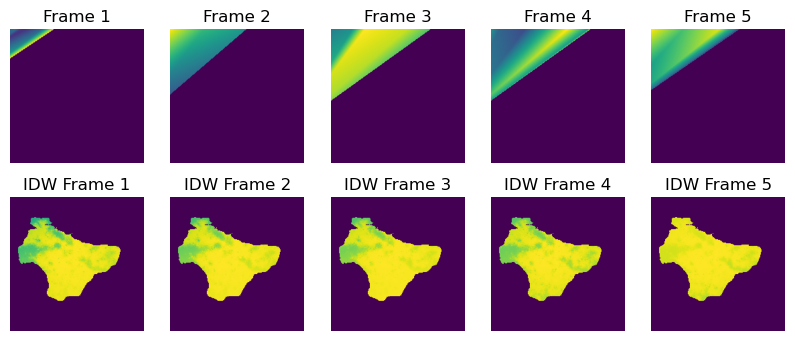

Target:  [20.  21.4 16.7]


In [12]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hysplit channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)))
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"IDW Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

In [13]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-15 17:06:20.745628: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 17:06:20.758864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 17:06:20.856559: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 17:06:20.936336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744761981.008482     937 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744761981.02

In [14]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 200, 200, 2))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(3,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

E0000 00:00:1744761983.439562     937 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1744761983.439927     937 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │         9,240 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       600,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 670,534 (2.56 MB)

 Trainable params: 670,534 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 33.3528
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 19.9555
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 17.7782
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 13.3225
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 14.7157
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 14.4695
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 12.7217
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 12.7336
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 11.5002
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 12.0105
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 10.2327
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 10.7054
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 11.7052
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 10.6016
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 10.0232
Epoch 16/150
4/4 ━━━━━━━━━━━━━━━━━

In [16]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

(18, 3) (18, 3)


In [17]:
from skimage.metrics import mean_squared_error as mse

def rmse(y_pred, y_test):
    return np.sqrt(mse(y_pred, y_test))

def nrmse(y_pred, y_test):
    return rmse(y_pred, y_test) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HYSPLIT Concentration data\n")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(AD.air_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HYSPLIT Concentration data

Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 13.35
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 84.99%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 7.40
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 25.05%

Frame 2 (Hour 2) All Locations - Raw RMSE: 14.87
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 51.21%

Frame 3 (Hour 3) All Locations - Raw RMSE: 19.39
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 69.85%

Frame 4 (Hour 4) All Locations - Raw RMSE: 19.64
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 73.45%

Frame 5 (Hour 5


Visualizing model predictions vs actual values...


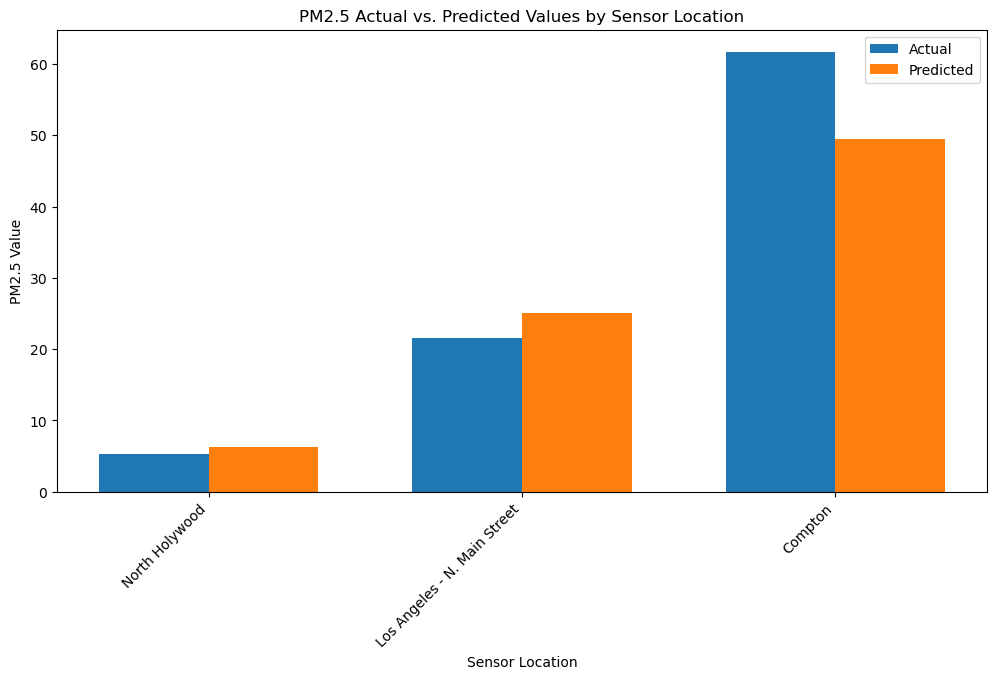

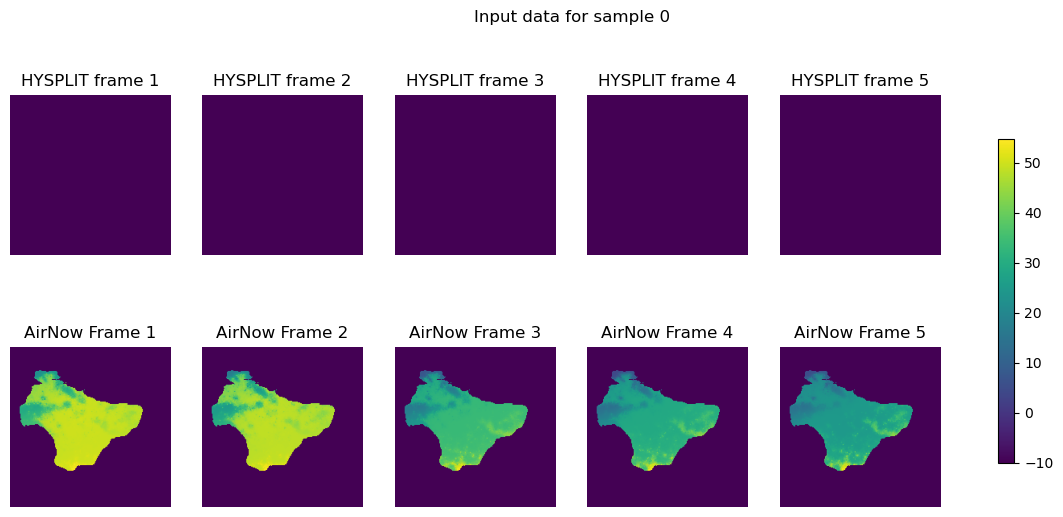

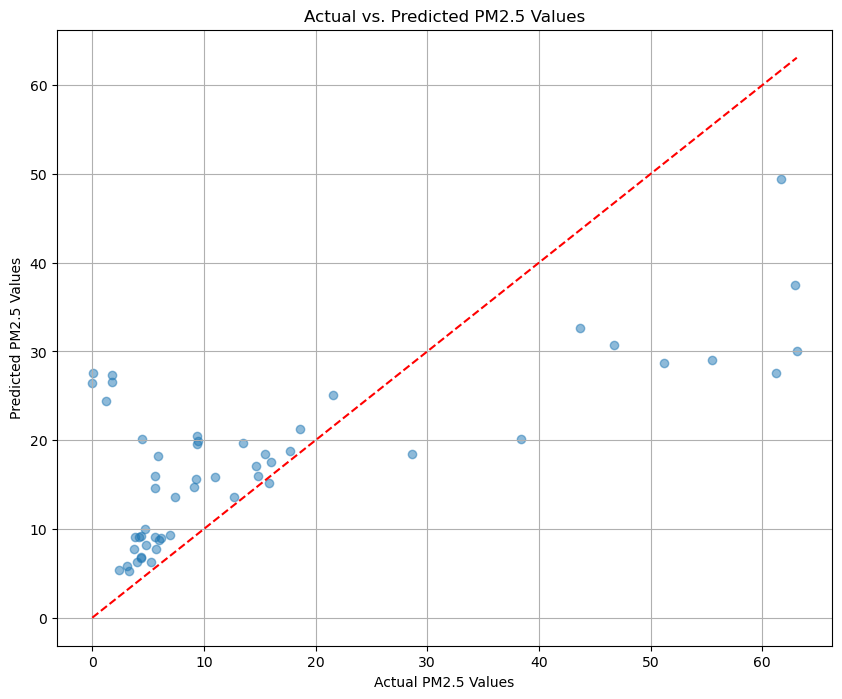

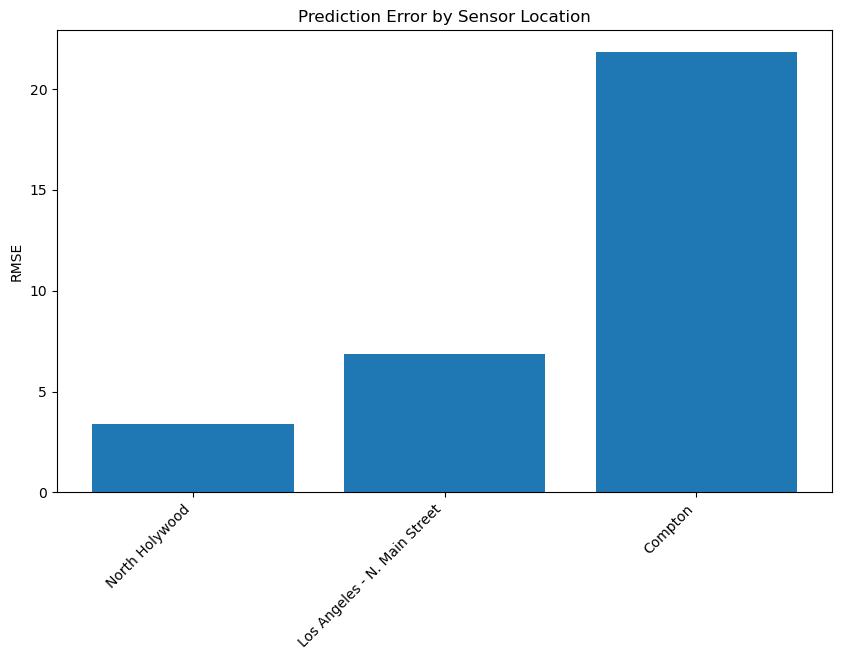

In [18]:
print("\nVisualizing model predictions vs actual values...")

# Choose the first test sample for consistent visualizations
sample_idx = 0

# Create a bar chart comparing predicted vs actual values for each sensor
fig, ax = plt.subplots(figsize=(12, 6))
sensor_names = list(AD.air_sens_loc.keys())
x = np.arange(len(sensor_names))
width = 0.35

true_vals = y_test[sample_idx]
pred_vals = y_pred[sample_idx]

rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
ax.set_ylabel('PM2.5 Value')
ax.set_xlabel('Sensor Location')
ax.set_xticks(x)
ax.set_xticklabels(sensor_names, rotation=45, ha='right')
ax.legend()

#plt.tight_layout()
plt.show()

# Visualize input data for a specific sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot HYSPLIT Concentration data (channel 0)
for idx, ax in enumerate(axes[0]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 0]), cmap='viridis')
    ax.set_title(f"HYSPLIT frame {idx + 1}")
    ax.axis("off")

# Plot AirNow data (channel 1)
for idx, ax in enumerate(axes[1]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 1]), cmap='viridis')
    ax.set_title(f"AirNow Frame {idx + 1}")
    ax.axis("off")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
plt.suptitle(f'Input data for sample {sample_idx}')
#plt.tight_layout()
plt.show()

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PM2.5 Values')
plt.ylabel('Predicted PM2.5 Values')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Compute error metrics for each sensor
error_by_sensor = []
for i, sensor in enumerate(sensor_names):
    error = rmse(y_pred[:, i], y_test[:, i])
    error_by_sensor.append(error)

# Create bar chart of errors by sensor
plt.figure(figsize=(10, 6))
plt.bar(sensor_names, error_by_sensor)
plt.ylabel('RMSE')
plt.title('Prediction Error by Sensor Location')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

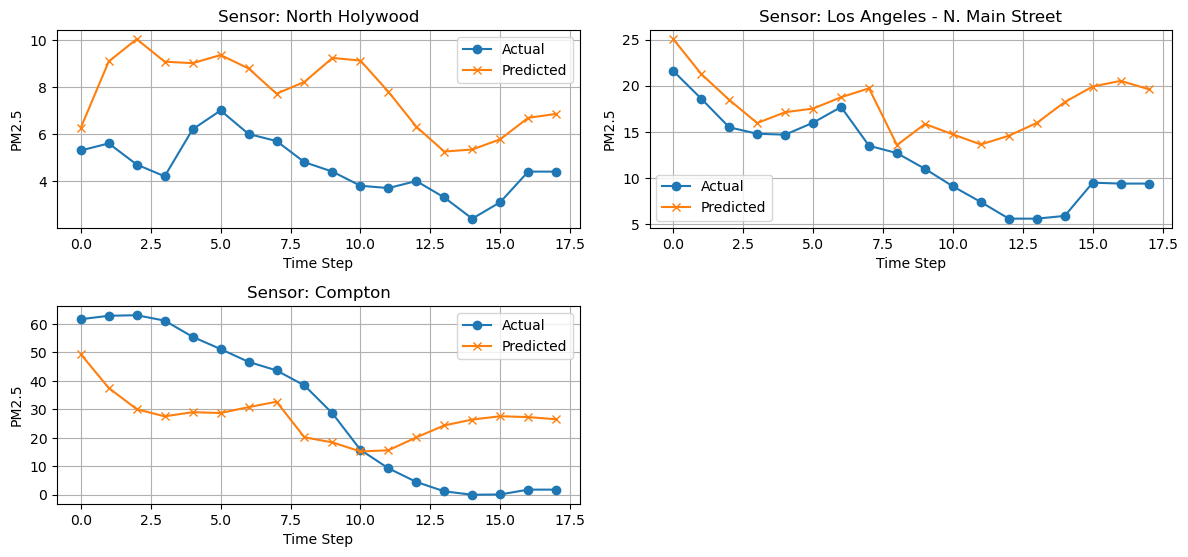


===== Sensor: North Holywood =====
MAE: 3.16
RMSE: 3.39

Values Table:
 Time Step  Actual PM2.5  Predicted PM2.5  Difference
         0           5.3         6.263074   -0.963074
         1           5.6         9.086432   -3.486432
         2           4.7        10.033949   -5.333949
         3           4.2         9.074537   -4.874537
         4           6.2         9.011100   -2.811100
         5           7.0         9.357283   -2.357283
         6           6.0         8.787978   -2.787978
         7           5.7         7.714291   -2.014291
         8           4.8         8.215737   -3.415737
         9           4.4         9.234550   -4.834550
        10           3.8         9.122390   -5.322390
        11           3.7         7.796163   -4.096163
        12           4.0         6.310000   -2.310000
        13           3.3         5.253335   -1.953335
        14           2.4         5.340957   -2.940957
        15           3.1         5.774590   -2.674590
        16

In [19]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Create DataFrames to display the actual and predicted values
import pandas as pd

# Create a dictionary to store DataFrames for each sensor
sensor_dfs = {}

for i, sensor in enumerate(AD.air_sens_loc.keys()):
    # Create a DataFrame for this sensor
    df = pd.DataFrame({
        'Time Step': range(len(y_test[:, i])),
        'Actual PM2.5': y_test[:, i],
        'Predicted PM2.5': y_pred[:, i],
        'Difference': y_test[:, i] - y_pred[:, i]
    })
    
    # Calculate error metrics for this sensor
    mae = np.mean(np.abs(y_test[:, i] - y_pred[:, i]))
    rmse_val = np.sqrt(np.mean((y_test[:, i] - y_pred[:, i])**2))
    
    print(f"\n===== Sensor: {sensor} =====")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse_val:.2f}")
    print("\nValues Table:")
    print(df.to_string(index=False))
    
    # Store the DataFrame
    sensor_dfs[sensor] = df

# If you want to create a comprehensive table with all sensors
all_data = pd.DataFrame()

for i, sensor in enumerate(AD.air_sens_loc.keys()):
    actual_col = f"{sensor}_Actual"
    pred_col = f"{sensor}_Predicted"
    
    temp_df = pd.DataFrame({
        actual_col: y_test[:, i],
        pred_col: y_pred[:, i]
    })
    
    if all_data.empty:
        all_data = temp_df
    else:
        all_data = pd.concat([all_data, temp_df], axis=1)

print("\n===== All Sensors Data =====")
print(all_data.to_string())



===== DATA LEAKAGE ANALYSIS =====

== Correlation Analysis between Sensors (Actual Values) ==


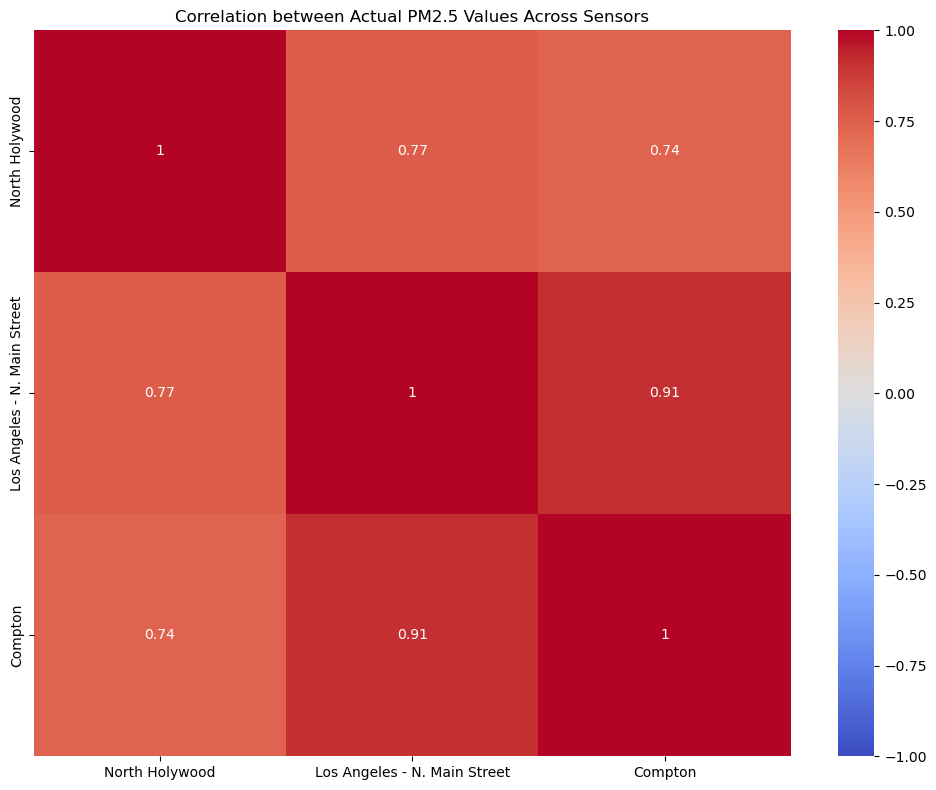

In [20]:
# Data Leakage Analysis Code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
import seaborn as sns

# 3. Data Leakage Analysis
print("\n\n===== DATA LEAKAGE ANALYSIS =====")

# 3.1 Check correlation between actual values across different sensors
print("\n== Correlation Analysis between Sensors (Actual Values) ==")
# Extract actual values for each sensor
actual_values = pd.DataFrame({sensor: y_test[:, i] for i, sensor in enumerate(AD.air_sens_loc.keys())})
correlation_matrix = actual_values.corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Actual PM2.5 Values Across Sensors')
plt.tight_layout()
plt.show()

## I think the issue here could be a lack of elevation data that is skewing our data heavily. We need to repeat IDW code but with elevation data.